In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries, data, and functions

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import pandas as pd
import mpl_toolkits.mplot3d as plt3d
matplotlib.rcParams.update({'font.size': 22})

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Reshape, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, UpSampling1D, Input
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split

In [17]:
def loss_function_col(y_true, y_pred):

  bs = len(y_true)
  y_true, y_pred = tf.reshape(y_true, (bs,3,3)), tf.reshape(y_pred,(bs,3,3)) 

  perm_rows = tf.linalg.LinearOperatorPermutation([1,2,0])
  true_dist = tf.sqrt(tf.reduce_sum(tf.math.squared_difference( y_true, tf.matmul(perm_rows,y_true) ), axis=-1, keepdims=True))
  pred_dist = tf.sqrt(tf.reduce_sum(tf.math.squared_difference( y_pred, tf.matmul(perm_rows,y_pred) ), axis=-1, keepdims=True))

  return tf.square( tf.reduce_sum( tf.abs( tf.math.subtract(true_dist, pred_dist) ) , axis = 1)  )

In [18]:
#Function which plots the 3D traingle

def Plot_2(v1, v2, v3, vv1, vv2, vv3):
  fig = plt.figure()
  fig.set_size_inches(5,5)
  ax = fig.add_subplot(111, projection='3d')
  
  X = np.array([v1,v2,v3])
  Y = np.array([vv1,vv2,vv3])
  
  l0x, ll0x = np.linspace(v1[0], v2[0], 50), np.linspace(vv1[0], vv2[0], 50)
  l1x, ll1x = np.linspace(v2[0], v3[0], 50), np.linspace(vv2[0], vv3[0], 50)
  l2x, ll2x = np.linspace(v3[0], v1[0], 50), np.linspace(vv3[0], vv1[0], 50)
  l0y, ll0y = np.linspace(v1[1], v2[1], 50), np.linspace(vv1[1], vv2[1], 50)
  l1y, ll1y = np.linspace(v2[1], v3[1], 50), np.linspace(vv2[1], vv3[1], 50)
  l2y, ll2y = np.linspace(v3[1], v1[1], 50), np.linspace(vv3[1], vv1[1], 50)
  l0z, ll0z = np.linspace(v1[2], v2[2], 50), np.linspace(vv1[2], vv2[2], 50)
  l1z, ll1z = np.linspace(v2[2], v3[2], 50), np.linspace(vv2[2], vv3[2], 50)
  l2z, ll2z = np.linspace(v3[2], v1[2], 50), np.linspace(vv3[2], vv1[2], 50)

  #Drawing lines
  ax.scatter(l0x, l0y, l0z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll0x, ll0y, ll0z, color='black', marker='s', s = 1, alpha = 0.1)
  ax.scatter(l1x, l1y, l1z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll1x, ll1y, ll1z, color='black', marker='s', s = 1, alpha = 0.1)
  ax.scatter(l2x, l2y, l2z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll2x, ll2y, ll2z, color='black', marker='s', s = 1, alpha = 0.1)


  #plot the nodes
  for x, y, z in X:
    ax.scatter(x, y, z, color='red', marker='o', s=30)
  for x, y, z in Y:
    ax.scatter(x, y, z, color='black', marker='o', s=30)

  ax.scatter(0, 0, 0, color='blue', marker='s', s = 0.01 )
  ax.scatter(1, 0, 0, color='blue', marker='s', s = 0.01 )
  ax.scatter(0, 1, 0, color='blue', marker='s', s = 0.01 )
  ax.scatter(0, 0, 1, color='blue', marker='s', s = 0.01 )
  ax.scatter(1, 1, 1, color='blue', marker='s', s = 0.01 )

In [19]:
def side_lens(v):
  vx,vy,vz = np.array_split(v , 3)
  return np.array([np.linalg.norm(vx-vy), 
                   np.linalg.norm(vy-vz), 
                   np.linalg.norm(vz-vx)])

This cell is for importing larger datasets from google drive instead of remaking them.

## **LJ-Potential** -   $V_{\mathrm{LJ}}(r)=4\left(\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^{6}\right)$

In [15]:
def LJ(r, sigma):
  return 4*( (sigma/r)**12 - (sigma/r)**6) 

## Prep

### Loading in models

In [11]:
en_predictor_sid = keras.models.load_model("/content/drive/MyDrive/Project/Custom_loss/En_Pred_Sid")
en_predictor_lat = keras.models.load_model("/content/drive/MyDrive/Project/Custom_loss/En_Pred_Lat")
en_predictor_euc = keras.models.load_model("/content/drive/MyDrive/Project/Custom_loss/En_Pred_Euc")
encoder          = keras.models.load_model("/content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Encoder")
#encoder_2        = keras.models.load_model("/content/drive/MyDrive/Project/Custom_loss/Symm_AE2")

### Prepping data

In [12]:
# Loading data in from dataframe, and parsing
dtf = pd.read_csv('/content/drive/MyDrive/Project/Autoencoder triangular molecule/training/Symm_data_rnd.csv')

In [13]:
def normalize(x,x_min,x_max):
  return (x-x_min) / (x_max-x_min)

def unnormalize(x,x_min,x_max):
  return x*(x_max-x_min)+x_min

In [23]:
# Euclidean data
x_data_euc = np.array([dtf['x1'],dtf['y1'],dtf['z1'],
                       dtf['x2'],dtf['y2'],dtf['z2'],
                       dtf['x3'],dtf['y3'],dtf['z3'] ]).T

# Side len data
x_data_sid = np.array([dtf['L1'],
                       dtf['L2'],
                       dtf['L3']]).T

# Latent space data
x_data_lat = encoder.predict(x_data_euc)

#x_min_lat,x_max_lat  = np.min(x_data_lat), np.max(x_data_lat) 
#x_data_lat = normalize(x_data_lat, x_min_lat,x_max_lat)

# LJ-energy data
y_data     = np.sum(2*LJ(x_data_sid, .5), axis=-1)

y_min, y_max  = np.min(y_data), np.max(y_data) 
y_data = normalize(y_data,y_min,y_max)

In [24]:
# Splitting the array into validation, training, and test sets

# Euclidean training x-data
x_train_euc,  x_val_euc = train_test_split(x_data_euc , test_size = 0.1  , shuffle = False)
x_train_euc, x_test_euc = train_test_split(x_train_euc, test_size = 1./9., shuffle = False)

# Side training x-data
x_train_sid,  x_val_sid = train_test_split( x_data_sid , test_size = 0.1 , shuffle = False)
x_train_sid, x_test_sid = train_test_split(x_train_sid, test_size = 1./9., shuffle = False)

# Latent variables training x-data
x_train_lat, x_val_lat  = train_test_split(x_data_lat , test_size = 0.1  , shuffle = False)
x_train_lat, x_test_lat = train_test_split(x_train_lat, test_size = 1./9., shuffle = False)

# Energy y-data
y_train, y_val          = train_test_split(y_data     , test_size = 0.1  , shuffle = False)
y_train, y_test         = train_test_split(y_train    , test_size = 1./9., shuffle = False)

In [25]:
loss_l = en_predictor_lat.evaluate(x_test_lat,y_test)
loss_s = en_predictor_sid.evaluate(x_test_sid,y_test)
loss_e = en_predictor_euc.evaluate(x_test_euc,y_test)

print('side loss = ', loss_s,"\n",
      'latent loss = ', loss_l,"\n",
      'euclid loss = ', loss_e,"\n")

625/625 [==============================] - 1s 996us/step - loss: 0.0012
side loss =  0.0011553192744031549 
 latent loss =  0.9745198488235474 
 euclid loss =  0.0012104863999411464 



Latent Models performance


In [ ]:
m = keras.models.load_model("/content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Model", compile=False)
m.compile(loss = loss_function_col)
m.evaluate(x_test_euc,x_test_euc)

## Evaluation


### Euclidean Model

625/625 [==============================] - 1s 871us/step - loss: 4.6007e-04


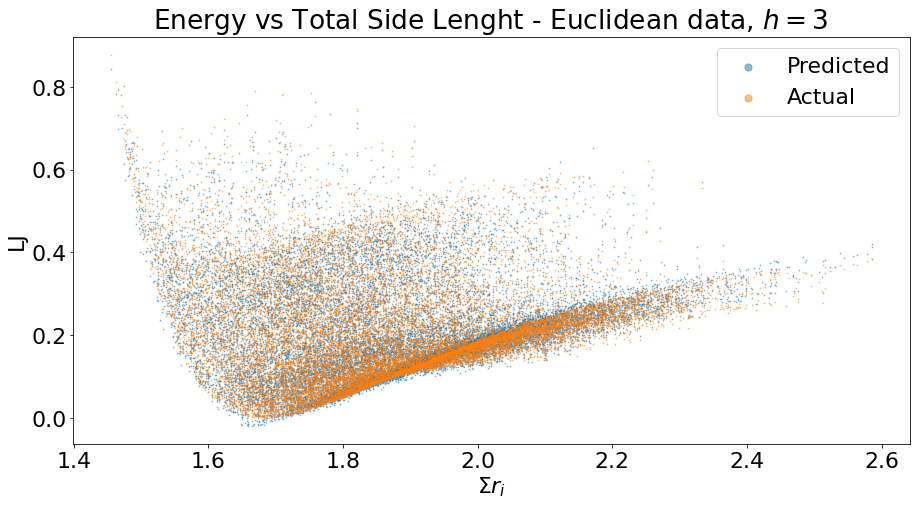

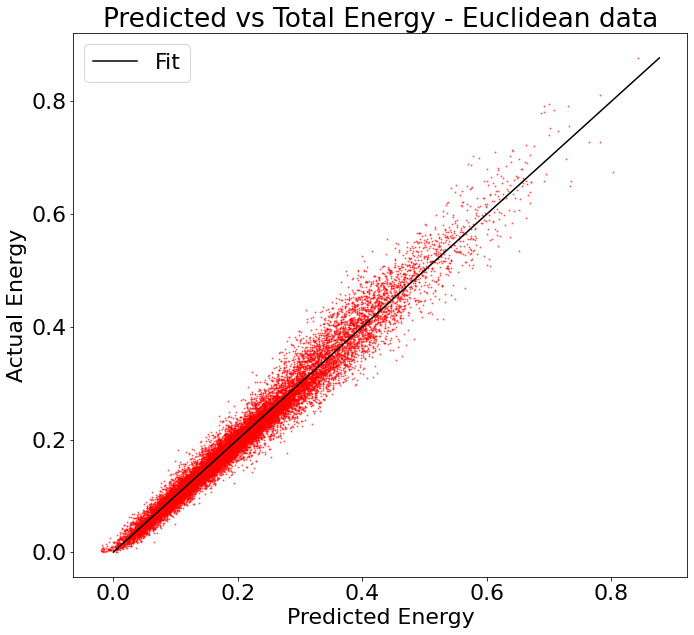

In [ ]:
# Eval on test set
en_predictor_euc.evaluate(x_test_euc, y_test)

r   = np.sum(x_test_sid[:], axis = -1) # Tot side len
Ens = y_test
pred_ens = en_predictor_euc.predict(x_test_euc)
# Plotting Predicted energy vs tot side lin
plt.figure( figsize=(15,7.5) )
plt.title( 'Energy vs Total Side Lenght - Euclidean data, $h=3$ ' )
plt.scatter(r, pred_ens, alpha = 0.5, s = .5, label = 'Predicted')
plt.scatter(r, Ens,      alpha = 0.5, s = .5, label = 'Actual')
plt.legend(markerscale=10,scatterpoints=1)
plt.xlabel('$\Sigma r_i$')
plt.ylabel('LJ')
plt.show()

# Plotting Predicted energy vs Actual
plt.figure( figsize=(11,10) )

plt.title( 'Predicted vs Total Energy - Euclidean data' )
plt.scatter(pred_ens, Ens, alpha = .5, s = 1, c = 'r')
plt.plot( np.linspace(np.min(Ens),np.max(Ens)),np.linspace(np.min(Ens),np.max(Ens)), c = 'k', label = 'Fit')
plt.xlabel('Predicted Energy')
plt.ylabel('Actual Energy')
plt.legend(markerscale=10,scatterpoints=1)
plt.savefig('/content/drive/MyDrive/Symmester 2/Final year project/Writeup/Diagrams/act_vs_pred_en_euc', transparent=True)
plt.show()

### Side Model

625/625 [==============================] - 1s 851us/step - loss: 6.4715e-06


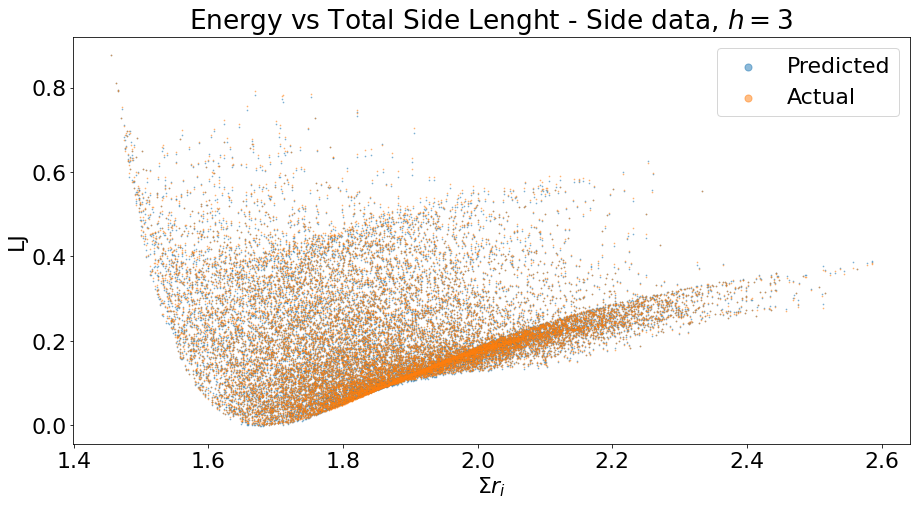

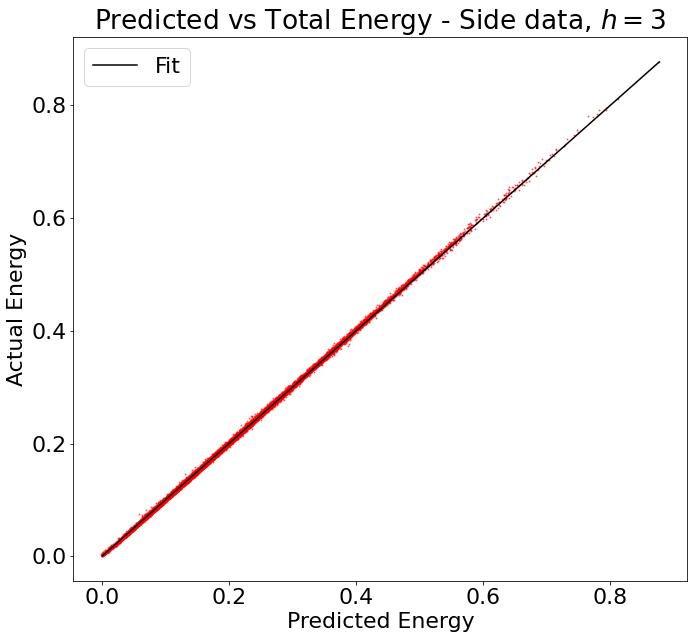

In [ ]:
# Eval on test set
en_predictor_sid.evaluate(x_test_sid, y_test)

r   = np.sum(x_test_sid[:], axis = -1) # Tot side len

# Plotting Predicted energy vs tot side lin
pred_ens = en_predictor_sid.predict(x_test_sid)
plt.figure( figsize=(15,7.5) )
plt.title( 'Energy vs Total Side Lenght - Side data, $h=3$ ' )
plt.scatter(r, pred_ens, alpha = 0.5, s = .5, label = 'Predicted')
plt.scatter(r, Ens,      alpha = 0.5, s = .5, label = 'Actual')
plt.legend(markerscale=10,scatterpoints=1)
plt.xlabel('$\Sigma r_i$')
plt.ylabel('LJ')
plt.show()

# Plotting Predicted energy vs Actual
plt.figure( figsize=(11,10) )
plt.title( 'Predicted vs Total Energy - Side data, $h=3$' )
plt.scatter(pred_ens, Ens, alpha = .5, s = 1, c = 'r')
plt.plot( np.linspace(np.min(Ens),np.max(Ens)),np.linspace(np.min(Ens),np.max(Ens)), c = 'k', label = 'Fit')
plt.xlabel('Predicted Energy')
plt.ylabel('Actual Energy')
plt.legend(markerscale=10,scatterpoints=1)
plt.savefig('/content/drive/MyDrive/Symmester 2/Final year project/Writeup/Diagrams/act_vs_pred_en_sid', transparent=True)
plt.show()

### Latent Model

625/625 [==============================] - 0s 779us/step - loss: 9.5366e-05


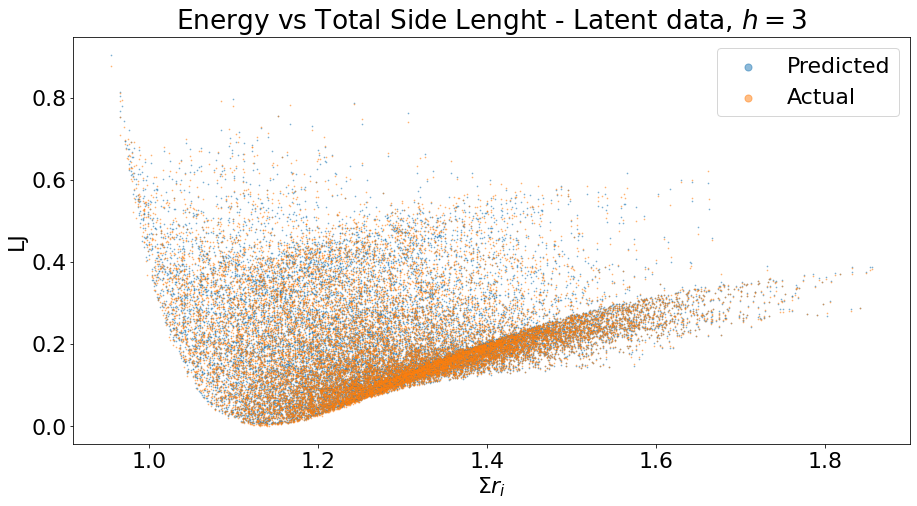

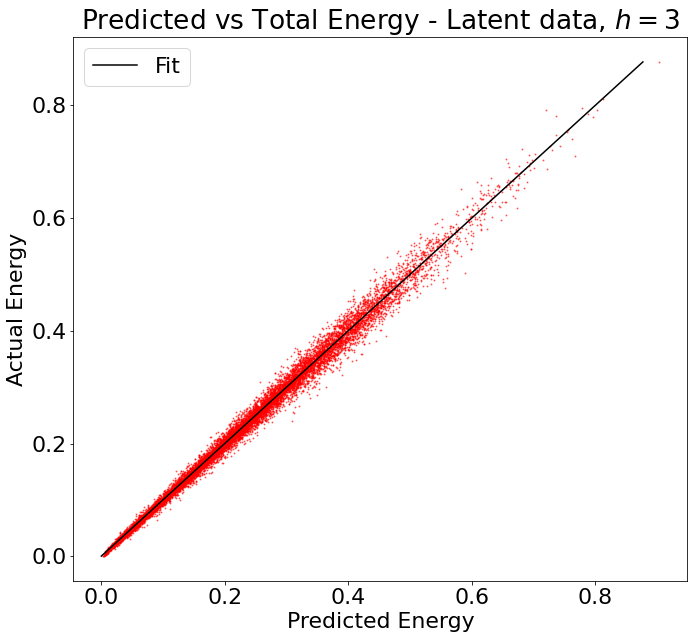

In [ ]:
# Eval on test set
en_predictor_lat.evaluate(x_test_lat, y_test)

r        = np.sum(x_test_lat[:], axis = -1) # Tot node len
pred_ens = en_predictor_lat.predict(x_test_lat)

# Plotting Predicted energy vs tot side lin
plt.figure( figsize=(15,7.5) )
plt.title( 'Energy vs Total Side Lenght - Latent data, $h=3$' )
plt.scatter(r, pred_ens, alpha = 0.5, s = .5, label = 'Predicted')
plt.scatter(r, Ens,      alpha = 0.5, s = .5, label = 'Actual')
plt.legend(markerscale=10,scatterpoints=1)
plt.xlabel('$\Sigma r_i$')
plt.ylabel('LJ')
plt.show()

# Plotting Predicted energy vs Actual
plt.figure( figsize=(11,10) )
plt.title( 'Predicted vs Total Energy - Latent data, $h=3$' )
plt.scatter(pred_ens, Ens, alpha = .5, s = 1, c = 'r')
plt.plot( np.linspace(np.min(Ens),np.max(Ens)),np.linspace(np.min(Ens),np.max(Ens)), c = 'k', label = 'Fit')
plt.xlabel('Predicted Energy')
plt.ylabel('Actual Energy')
plt.legend(markerscale=10,scatterpoints=1)
plt.savefig('/content/drive/MyDrive/Symmester 2/Final year project/Writeup/Diagrams/act_vs_pred_en_lat', transparent=True)
plt.show()

### Recovering a prediction of the LJ potential

Start with a triangle whth two sides far apart

In [ ]:
num_samp = 20000
sigma =   .5 # Scaling 
(min,max) = (0,1.3)
# 3 vectors determining initial triangle
p1 = np.array([0, 1, 0  ]) 
p2 = np.array([0,.46, 0 ])
p3 = np.array([0, 0, 0]) # Vary p3


increment = np.linspace( min, max, num_samp)

In [ ]:
coord_vec = np.zeros( (num_samp, 9) )
for i in range(num_samp):
  p3 = np.array([0,0,increment[i]])
  coord_vec[i] = np.concatenate((p1,p2,p3)) 

In [ ]:
side_lenghts = np.array([side_lens(coord_vec[i]) for i in range(num_samp)])

In [ ]:
# Creating an array with the LJ-Energy for each particle
ei = LJ(side_lenghts, sigma)

# Summing and multiplying by two to retrieve the molecules tot en
ens = np.array(2*(np.sum(ei, axis = 1)))

In [ ]:
lat_data = encoder.predict(coord_vec) 
sid_data = side_lenghts
euc_data = coord_vec

lat_preds = unnormalize(en_predictor_lat.predict(normalize(lat_data, x_min_lat,x_max_lat)), y_min,y_max)
sid_preds = unnormalize(en_predictor_sid.predict(sid_data), y_min,y_max)
euc_preds = unnormalize(en_predictor_euc.predict(euc_data), y_min,y_max)

ens = 2*(LJ(side_lenghts[:,2], sigma) + LJ(side_lenghts[:,1], sigma) + LJ(side_lenghts[:,0], sigma)) 

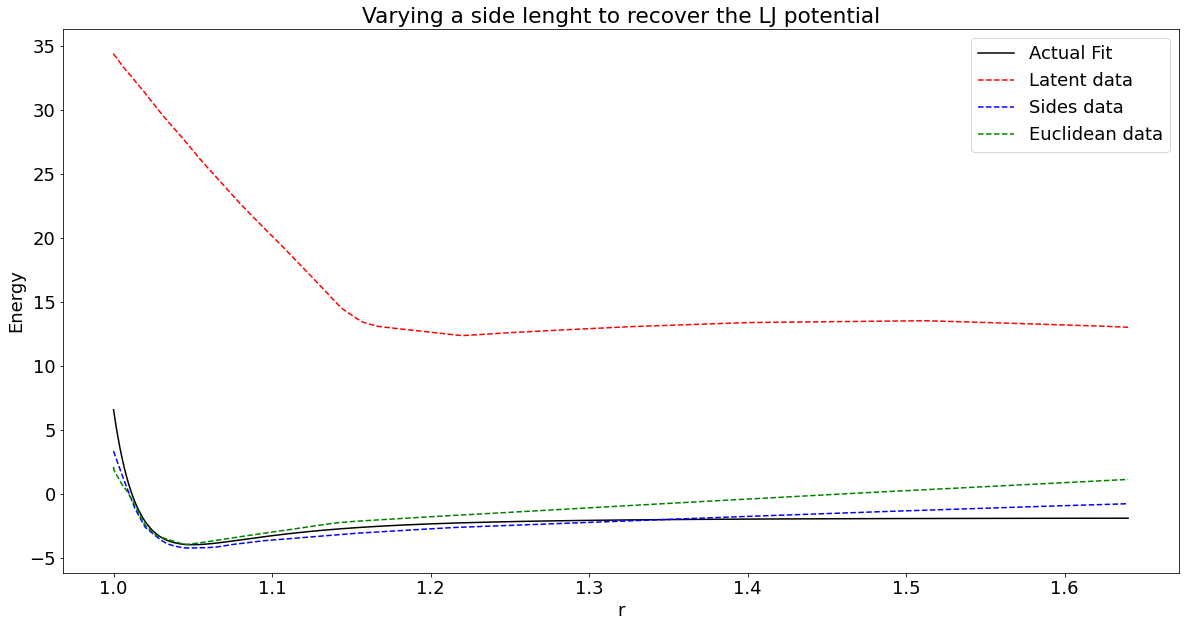

In [ ]:
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,10))

plt.title( 'Varying a side lenght to recover the LJ potential' )
plt.xlabel('r')
plt.ylabel('Energy')
plt.plot(side_lenghts[:,2], ens,         'k', label = 'Actual Fit')
plt.plot(side_lenghts[:,2], lat_preds, 'r--', label = 'Latent data')
plt.plot(side_lenghts[:,2], sid_preds, 'b--', label = 'Sides data')
plt.plot(side_lenghts[:,2], euc_preds, 'g--', label = 'Euclidean data')
plt.legend()
plt.savefig('/content/drive/MyDrive/Symmester 2/Final year project/Writeup/Diagrams/recovering_LJ', transparent=True)
plt.show()